# Setup

In [1]:
import torch
import tqdm
from tensordict.nn import TensorDictModule as Mod, TensorDictSequential as Seq
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, TensorDictReplayBuffer
from torchrl.envs import (
    Compose,
    ExplorationType,
    GrayScale,
    InitTracker,
    ObservationNorm,
    Resize,
    RewardScaling,
    set_exploration_type,
    StepCounter,
    ToTensorImage,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.modules import ConvNet, EGreedyWrapper, LSTMModule, MLP, QValueModule
from torchrl.objectives import DQNLoss, SoftUpdate

device = torch.device(0) if torch.cuda.device_count() else torch.device("cpu")

# Environment

In [1]:
env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True, device=device),
    Compose(
        ToTensorImage(),
        GrayScale(),
        Resize(84, 84),
        StepCounter(),
        InitTracker(),
        RewardScaling(loc=0.0, scale=0.1),
        ObservationNorm(standard_normal=True, in_keys=["pixels"]),
    ),
)

NameError: name 'TransformedEnv' is not defined

In [3]:
env.transform[-1].init_stats(1000, reduce_dim=[0, 1, 2], cat_dim=0, keep_dims=[0])
td = env.reset()

# Policy

In [4]:
feature = Mod(
    ConvNet(
        num_cells=[32, 32, 64],
        squeeze_output=True,
        aggregator_class=nn.AdaptiveAvgPool2d,
        aggregator_kwargs={"output_size": (1, 1)},
        device=device,
    ),
    in_keys=["pixels"],
    out_keys=["embed"],
)

/home/tikhon/PycharmProjects/RL/venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
n_cells = feature(env.reset())["embed"].shape[-1]

In [6]:
lstm = LSTMModule(
    input_size=n_cells,
    hidden_size=128,
    device=device,
    in_key="embed",
    out_key="embed",
)

In [7]:
print("in_keys", lstm.in_keys)
print("out_keys", lstm.out_keys)

in_keys ['embed', 'recurrent_state_h', 'recurrent_state_c', 'is_init']
out_keys ['embed', ('next', 'recurrent_state_h'), ('next', 'recurrent_state_c')]


In [8]:
env.append_transform(lstm.make_tensordict_primer())

In [9]:
print(env)

TransformedEnv(
    env=GymEnv(env=CartPole-v1, batch_size=torch.Size([]), device=cpu),
    transform=Compose(
            ToTensorImage(keys=['pixels']),
            GrayScale(keys=['pixels']),
            Resize(w=84, h=84, interpolation=InterpolationMode.BILINEAR, keys=['pixels']),
            StepCounter(keys=[]),
            InitTracker(keys=[]),
            RewardScaling(loc=0.0000, scale=0.1000, keys=['reward']),
            ObservationNorm(keys=['pixels']),
            TensorDictPrimer(primers=CompositeSpec(
                recurrent_state_h: UnboundedContinuousTensorSpec(
                    shape=torch.Size([1, 128]),
                    space=None,
                    device=cpu,
                    dtype=torch.float32,
                    domain=continuous),
                recurrent_state_c: UnboundedContinuousTensorSpec(
                    shape=torch.Size([1, 128]),
                    space=None,
                    device=cpu,
                    dtype=torch.float32,


In [10]:
mlp = MLP(
    out_features=2,
    num_cells=[
        64,
    ],
    device=device,
)

In [11]:
mlp[-1].bias.data.fill_(0.0)
mlp = Mod(mlp, in_keys=["embed"], out_keys=["action_value"])

In [12]:
qval = QValueModule(action_space=env.action_spec)

In [13]:
stoch_policy = Seq(feature, lstm, mlp, qval)

In [14]:
stoch_policy = EGreedyWrapper(
    stoch_policy, annealing_num_steps=1_000_000, spec=env.action_spec, eps_init=0.2
)

In [15]:
policy = Seq(feature, lstm.set_recurrent_mode(True), mlp, qval)


In [16]:
policy(env.reset())

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        embed: Tensor(shape=torch.Size([128]), device=cpu, dtype=torch.float32, is_shared=False),
        is_init: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                recurrent_state_c: Tensor(shape=torch.Size([1, 128]), device=cpu, dtype=torch.float32, is_shared=False),
                recurrent_state_h: Tensor(shape=torch.Size([1, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),

In [17]:
loss_fn = DQNLoss(policy, action_space=env.action_spec, delay_value=True)


In [18]:
updater = SoftUpdate(loss_fn, eps=0.95)

optim = torch.optim.Adam(policy.parameters(), lr=3e-4)

In [19]:
collector = SyncDataCollector(env, stoch_policy, frames_per_batch=50, total_frames=200)
rb = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(20_000), batch_size=4, prefetch=10
)

In [20]:
utd = 16
pbar = tqdm.tqdm(total=1_000_000)
longest = 0

traj_lens = []
for i, data in enumerate(collector):
    if i == 0:
        print(
            "Let us print the first batch of data.\nPay attention to the key names "
            "which will reflect what can be found in this data structure, in particular: "
            "the output of the QValueModule (action_values, action and chosen_action_value),"
            "the 'is_init' key that will tell us if a step is initial or not, and the "
            "recurrent_state keys.\n",
            data,
        )
    pbar.update(data.numel())
    # it is important to pass data that is not flattened
    rb.extend(data.unsqueeze(0).to_tensordict().cpu())
    for _ in range(utd):
        s = rb.sample().to(device, non_blocking=True)
        loss_vals = loss_fn(s)
        loss_vals["loss"].backward()
        optim.step()
        optim.zero_grad()
    longest = max(longest, data["step_count"].max().item())
    pbar.set_description(
        f"steps: {longest}, loss_val: {loss_vals['loss'].item(): 4.4f}, action_spread: {data['action'].sum(0)}"
    )
    stoch_policy.step(data.numel())
    updater.step()

    with set_exploration_type(ExplorationType.MODE), torch.no_grad():
        rollout = env.rollout(10000, stoch_policy)
        traj_lens.append(rollout.get(("next", "step_count")).max().item())

  0%|          | 50/1000000 [00:00<4:24:59, 62.89it/s]

Let us print the first batch of data.
Pay attention to the key names which will reflect what can be found in this data structure, in particular: the output of the QValueModule (action_values, action and chosen_action_value),the 'is_init' key that will tell us if a step is initial or not, and the recurrent_state keys.
 TensorDict(
    fields={
        action: Tensor(shape=torch.Size([50, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([50]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([50]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        is_init: Tensor(shape=torch.Size([50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([50, 1]), devi

steps: 15, loss_val:  0.0005, action_spread: tensor([ 7, 43]):   0%|          | 200/1000000 [02:39<187:00:42,  1.49it/s]

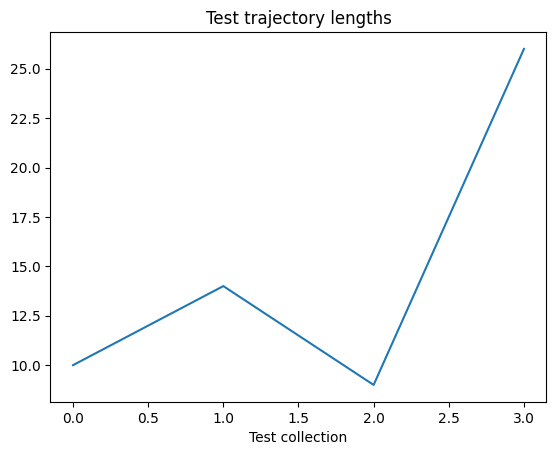

In [21]:
if traj_lens:
    from matplotlib import pyplot as plt

    plt.plot(traj_lens)
    plt.xlabel("Test collection")
    plt.title("Test trajectory lengths")

In [22]:
rb.sample().to(device, non_blocking=True)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4, 50, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([4, 50]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([4, 50]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([4, 50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([4, 50]), device=cpu, dtype=torch.int64, is_shared=False),
        is_init: Tensor(shape=torch.Size([4, 50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([4, 50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                is_init: Tensor(shape=torch.Size([4, 50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: Tensor(shape=torch.Size([4